# ST446 Distributed Computing for Big Data
## Seminar class 7: Scalable machine learning I

In this notebook we run logistic regression using the `LogisticRegressionWithLBFGS`, `LogisticRegressionWithSGD` and `LogisticRegressionModel` models from `pyspark.mllib`. 
We aim at comparing the computation time and the training error when using different optimization methods.

Note: `spark.mllib` operates on RDDs, whereas `spark.ml` operates on DataFrames.
As of Spark 2.0, the RDD-based APIs in the `spark.mllib` package have entered maintenance mode. The primary Machine Learning API for Spark is now the DataFrame-based API in the `spark.ml` package. 
We use the `mllib` here for illustration purpose only. 

While the SGD algorithm is quite similar to what we've seen in the previous notebook, here most of the calculations are hidden behind APIs.

Reference: https://spark.apache.org/docs/2.1.0/api/python/pyspark.mllib.html#pyspark.mllib.classification.LogisticRegressionModel

## 1. Load data

In [1]:
# change to where spark lives on your machine/compute engine
spark_home = "file:///usr/lib/spark"

In [5]:
# import ML models
from pyspark.mllib.classification import LogisticRegressionWithLBFGS, LogisticRegressionWithSGD, LogisticRegressionModel
from pyspark.mllib.regression import LabeledPoint

import os

# Load and parse the data
def parsePoint(line):
    values = [float(x) for x in line.split(' ')]
    return LabeledPoint(values[0], values[1:])

# dataset to be used
data = sc.textFile(spark_home+"/data/mllib/sample_svm_data.txt")
parsedData = data.map(parsePoint)

# Split dataset into training end testing portion (50% each)
train, test = parsedData.randomSplit([0.5, 0.5], seed=10)

## 2. Fitting logistic regression

### a. Logistic regression using SGD

You can set the fraction of data to be used for each SGD iteration by providing the argument `miniBatchFraction`. See http://spark.apache.org/docs/2.0.0/api/python/pyspark.mllib.html#pyspark.mllib.classification.LogisticRegressionWithSGD for more details on how to change the batch sizes and how to include regularisation.

Here, we have included some regularisation and reduced the step size of SGD a little bit to improve convergence.

![SGD](./fig/SGD.png)

In [6]:
# Build the SGD model
model_sgd = LogisticRegressionWithSGD.train(parsedData,step=.5,regParam=0.1)

# Evaluating the model on training data
labelsAndPreds_sgd = parsedData.map(lambda p: (p.label, model_sgd.predict(p.features)))
trainErr_sgd = labelsAndPreds_sgd.filter(lambda lp: lp[0] != lp[1]).count() / float(parsedData.count())
print("Training error: " + str(trainErr_sgd)) # fraction of mis-classified data points

# Print model
print("Final weights: " + str(model_sgd.weights))
print("Final intercept: " + str(model_sgd.intercept))

Training error: 0.36335403726708076
Final weights: [-0.1311091080586503,0.002651229868573788,-0.03993885100846145,0.17459121591044865,-0.0946161427955929,0.003503389506560456,0.1216816941223905,-0.19635743999268132,0.023017290602351425,0.02301729060235143,0.1510627297097451,-0.10741426874902109,0.11299258999463906,-0.0693281282429334,-0.032374291325156034,0.07874856054850413]
Final intercept: 0.0


### b. Logistic regression using LBFGS
![LBFGS](./fig/LBFGS.png)

In [7]:
# Build the LBFGS model
model_lbfgs = LogisticRegressionWithLBFGS.train(parsedData,regParam=0.1)

# Evaluate the model on training data
labelsAndPreds_lbfgs = parsedData.map(lambda p: (p.label, model_lbfgs.predict(p.features)))
trainErr_lbfgs = labelsAndPreds_lbfgs.filter(lambda lp: lp[0] != lp[1]).count() / float(parsedData.count())
print("Training error: " + str(trainErr_lbfgs))

# Print model
print("Final weights: " + str(model_lbfgs.weights))
print("Final intercept: " + str(model_lbfgs.intercept))

Training error: 0.36335403726708076
Final weights: [-0.14194264021919878,-0.0070902160250298505,-0.03188177632683626,0.19838077547106756,-0.10456240495990102,-0.004115728919292222,0.12896988546869956,-0.21299087467694539,0.02194319781079003,0.021943197810790033,0.1732259732456029,-0.1214269957453308,0.13560552637465048,-0.09280325724294307,-0.053909647303836614,0.10330906593046994]
Final intercept: 0.0


## 3. Compare number of iteration vs error and computation time

In [13]:
# import necessary libraries
import numpy as np
from time import time
import random
import matplotlib.pyplot as plt
%matplotlib inline

def classification_err(data, model):
    labelsAndPreds = data.map(lambda p: (p.label, model.predict(p.features)))
    err = labelsAndPreds.filter(lambda lp: lp[0] != lp[1]).count() / float(data.count())
    return (err)

def model_vs_iter(model_func, train, test, iteration):
    trainErr = np.zeros(iteration)
    testErr = np.zeros(iteration)
    computationTime = np.zeros(iteration)
    num_repeat = 5
    for j in range(num_repeat):
        for i in range(iteration):
            random.seed(j*10) # generate a new seed for every repetition
            t0 = time()
            model = model_func(train, i)
            t1 = time()
            computationTime[i] += (t1 - t0)/num_repeat
            trainErr[i] += classification_err(train, model)/num_repeat
            testErr[i] += classification_err(test, model)/num_repeat
    return trainErr, testErr, computationTime

train_err_lbfgs, test_err_lbfgs, computation_time_lbfgs = model_vs_iter(lambda data,maxiter: LogisticRegressionWithLBFGS.train(data, maxiter, regParam=0.1), train, test, 20)
train_err_sgd, test_err_sgd, computation_time_sgd       = model_vs_iter(lambda data,maxiter: LogisticRegressionWithSGD.train(data, maxiter, step=.2,regParam=0.1), train, test, 20)

### a. training error vs iteration

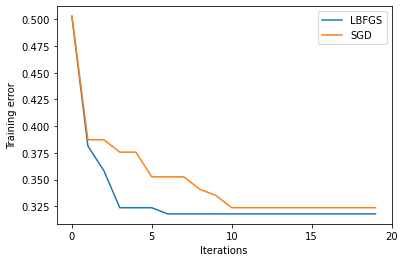

In [9]:
plt.plot(train_err_lbfgs, label = "LBFGS")
plt.plot(train_err_sgd, label = "SGD")
plt.xticks(np.arange(0, 21, 5))
plt.xlabel("Iterations")
plt.ylabel("Training error")
plt.legend()
plt.show();

### b. testing error vs iteration

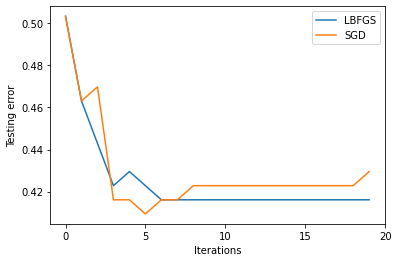

In [10]:
plt.plot(test_err_lbfgs, label = "LBFGS")
plt.plot(test_err_sgd, label = "SGD")
plt.xticks(np.arange(0, 21, 5))
plt.xlabel("Iterations")
plt.ylabel("Testing error")
plt.legend()
plt.show();

### c. computation time vs iteration

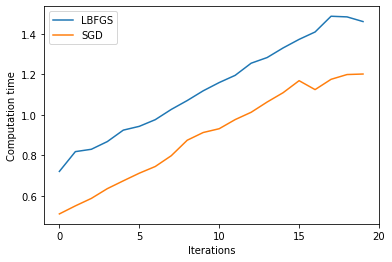

In [11]:
plt.plot(computation_time_lbfgs, label = "LBFGS")
plt.plot(computation_time_sgd, label = "SGD")
plt.xlabel("Iterations")
plt.ylabel("Computation time")
plt.legend()
plt.xticks(np.arange(0, 21, 5))
plt.show();

### e. computation time vs training error

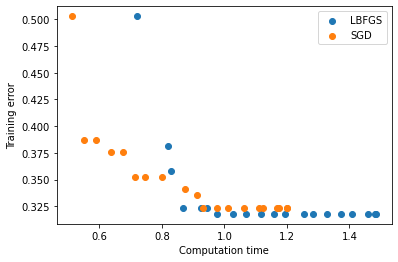

In [12]:
plt.scatter(computation_time_lbfgs, train_err_lbfgs, label = "LBFGS")
plt.scatter(computation_time_sgd, train_err_sgd, label = "SGD")
plt.xlabel("Computation time")
plt.ylabel("Training error")
plt.legend()
plt.show();

### f. computation time vs testing error

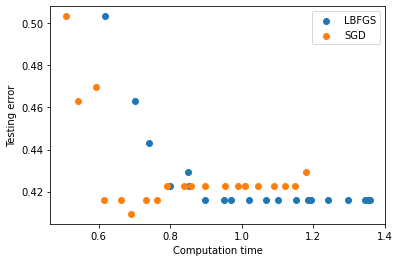

In [14]:
plt.scatter(computation_time_lbfgs, test_err_lbfgs, label = "LBFGS")
plt.scatter(computation_time_sgd, test_err_sgd, label = "SGD")
plt.xlabel("Computation time")
plt.ylabel("Testing error")
plt.legend()
plt.show();

What happens if you include regularisation?
Have a look at http://spark.apache.org/docs/2.0.0/api/python/pyspark.mllib.html#pyspark.mllib.classification.LogisticRegressionWithSGD
and http://spark.apache.org/docs/2.0.0/api/python/pyspark.mllib.html#pyspark.mllib.classification.LogisticRegressionWithLBFGS
to see how to include it.